In [1]:
## 数据读取与预处理操作
## 制作好数据源
## 读取标签对应的实际名字
## 展示下数据
## 加载models中提供的模型，并且直接用训练的好权重当做初始化参数
## 参考pytorch官网例子
## 设置哪些层需要训练
## 优化器设置
## 训练模块
## 开始训练！
## 再继续训练所有层
## 测试网络效果
## 加载训练好的模型
## 测试数据预处理
## 得到概率最大的那个
## 展示预测结果
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
import imageio
import warnings
import time
from PIL import Image
import json
import random
import sys
import copy

In [2]:
data_dir = './flower_data/'
train_dir = data_dir + 'train'
valid_dir = data_dir + 'valid'

In [3]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize(256),
                                transforms.RandomRotation(60),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.4, hue=0.5),
                                transforms.RandomGrayscale(p=0.03),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
    
    'valid': transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
}

In [4]:
batch_size = 16

image_set = {x:datasets.ImageFolder(os.path.join(data_dir + x), data_transforms[x]) for x in ['train', 'valid']}
data_set = {x:torch.utils.data.DataLoader(image_set[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}

image_sizes = {x: len(image_set[x]) for x in ['train', 'valid']}
class_names = image_set['train'].classes

In [5]:
image_set

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ./flower_data/train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                RandomRotation(degrees=[-60.0, 60.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=[0.8, 1.2], contrast=[0.7, 1.3], saturation=[0.6, 1.4], hue=[-0.5, 0.5])
                RandomGrayscale(p=0.03)
                ToTensor()
                Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ./flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(si

In [6]:
image_sizes

{'train': 6552, 'valid': 818}

In [7]:
with open('cat_to_name.json', 'r') as f:
    cat_to_names = json.load(f)
cat_to_names

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [8]:
## data exhibition
def im_convert(tensor):
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

tensor([83, 89, 84,  5, 87, 76, 51, 38, 18, 18, 46, 89, 78, 55, 49, 60])


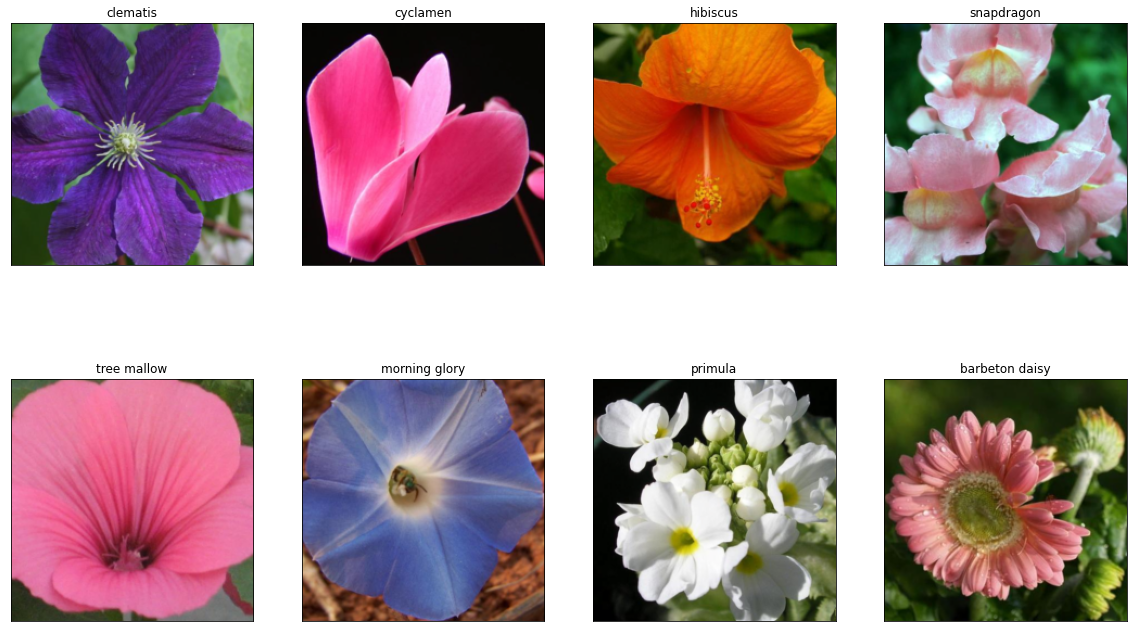

In [9]:
fig = plt.figure(figsize=(20,12))
cols = 4
rows = 2

dataiter = iter(data_set['valid'])
inputs, classes = dataiter.next()

print(classes)

for idx in range(cols*rows):
    ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_names[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))

plt.show()

In [10]:
## choose models
model = 'resnet'

## use features that have been trained
feature_extract = True 

In [11]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('use cpu')
else:
    print('use gpu')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

use gpu


In [12]:
## freeze layers
def set_params_required_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

In [16]:
model_ft = models.resnet152()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    
    if model_name == 'resnet':
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_params_required_grad(model_ft, feature_extract)
        nums_in_features = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(nums_in_features, num_classes), nn.LogSoftmax(dim=1))
        input_size = 224
        
    return model_ft, input_size

In [18]:
model_ft, input_size = initialize_model(model, 102, feature_extract, use_pretrained=True)

## GPU
model_ft = model_ft.to(device)

file_name = 'model_save.pth'

## Train all layers or not
update = model_ft.parameters()

print('params need to learn: ')
if feature_extract:
    params_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_update.append(param)
            print('\t', name)
            
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

params need to learn: 
	 fc.0.weight
	 fc.0.bias


In [19]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
## optimizer setting
optimizer_ft = optim.Adam(params_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.NLLLoss()

In [25]:
def train_model(model, data_set, optimizer, criterion, nums_epoch=30, is_inception=False, filename=file_name):
    model.to(device)
    best_acc = 0
    
    val_acc_history = []
    train_acc_history = []
    train_loss = []
    valid_loss = []
    LRs = [optimizer.param_groups[0]['lr']]
    
    best_model = copy.deepcopy(model.state_dict())
    
    for epoch in range(nums_epoch):
        print('Epoch {}/{}'.format(epoch, nums_epoch - 1))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            running_correct = 0
            running_loss = 0.0
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            ## take data
            for data, target in data_set[phase]:
                data = data.to(device)
                target = target.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    if is_inception and phase=='train':
                        output, aux_output = model(data)
                        loss1 = criterion(output, target)
                        loss2 = criterion(aux_output, target)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(data)
                        loss = criterion(outputs, target)
                        _, pred = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * data.size(0)
                running_correct += pred.eq(target.data.view_as(pred)).sum()
                
                epoch_loss = running_loss / len(data_set[phase].dataset)
                epoch_correct = running_correct.double() / len(data_set[phase].dataset)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_correct))
                
            if phase == 'valid' and epoch_correct > best_acc:
                best_acc = epoch_correct
                best_model = copy.deepcopy(model.state_dict())
                state = {
                        'state_dict':model.state_dict(),
                        'best_acc':best_acc,
                        'optimizer':optimizer.state_dict()
                    }
                torch.save(state, file_name)
                
            if phase == 'valid':
                val_acc_history.append(epoch_correct)
                valid_loss.append(epoch_loss)
                scheduler.step(epoch_loss)
                
            if phase == 'train':
                train_acc_history.append(epoch_correct)
                train_loss.append(epoch_loss)
                    
        LRs.append(optimizer.param_groups[0]['lr'])
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model)
    return model, train_acc_history, train_loss, val_acc_history, valid_loss, LRs

In [26]:
model_ft, train_acc_history, train_loss, val_acc_history, valid_loss, LRs = train_model(model_ft, data_set, optimizer_ft, criterion, 30)

Epoch 0/29
----------
train Loss: 5.1641 Acc: 0.4826
valid Loss: 4.9784 Acc: 0.5660


C:\Users\11986\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/29
----------
train Loss: 5.1867 Acc: 0.5571
valid Loss: 4.7438 Acc: 0.6247
Epoch 2/29
----------
train Loss: 5.0292 Acc: 0.6055
valid Loss: 3.7935 Acc: 0.7005
Epoch 3/29
----------
train Loss: 4.6068 Acc: 0.6482
valid Loss: 6.3814 Acc: 0.6100
Epoch 4/29
----------
train Loss: 4.8668 Acc: 0.6509
valid Loss: 4.9829 Acc: 0.6846
Epoch 5/29
----------
train Loss: 4.4782 Acc: 0.6798
valid Loss: 4.3554 Acc: 0.7518
Epoch 6/29
----------
train Loss: 4.5006 Acc: 0.6951
valid Loss: 3.9338 Acc: 0.7506
Epoch 7/29
----------
train Loss: 4.6685 Acc: 0.6983
valid Loss: 4.6390 Acc: 0.7017
Epoch 8/29
----------
train Loss: 4.5187 Acc: 0.7166
valid Loss: 5.2254 Acc: 0.6919
Epoch 9/29
----------
train Loss: 4.7437 Acc: 0.7146
valid Loss: 4.3839 Acc: 0.7604
Epoch 10/29
----------
train Loss: 4.5084 Acc: 0.7292
valid Loss: 5.5721 Acc: 0.7200
Epoch 11/29
----------
train Loss: 4.3681 Acc: 0.7341
valid Loss: 4.3214 Acc: 0.7653
Epoch 12/29
----------
train Loss: 4.5167 Acc: 0.7445
valid Loss: 4.7027 A

In [54]:
#Train the whole model
for param in model_ft.parameters():
    param.requires_grad == True
    
optimizer = optim.Adam(params_update, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.NLLLoss()

check_point = torch.load(file_name)
best_acc = check_point['best_acc']
model_ft.load_state_dict(check_point['state_dict'])
optimizer.load_state_dict(check_point['optimizer'])

best_model, train_acc_history, train_loss, val_acc_history, valid_loss, LRs = train_model(model_ft, data_set, optimizer, criterion, 4)

Epoch 0/3
----------
train Loss: 4.0815 Acc: 0.7985
valid Loss: 4.3067 Acc: 0.8264
Epoch 1/3
----------
train Loss: 4.2066 Acc: 0.7970
valid Loss: 3.8207 Acc: 0.8423
Epoch 2/3
----------
train Loss: 4.2830 Acc: 0.7959
valid Loss: 3.9206 Acc: 0.8374
Epoch 3/3
----------
train Loss: 4.4340 Acc: 0.7966
valid Loss: 4.7939 Acc: 0.8178
Best val Acc: 0.842298


In [56]:
### Testing
model_ft, input_size = initialize_model(model, 102, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)
file_name='model_save.pth'
checkpoint = torch.load(file_name)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [57]:
def process_image(img_path):
    image = Image.open(img_path)
    if image.size[0] > image.size[1]:
        image.thumbnail(10000, 256)
    else:
        image.thumbnail(256, 10000)
    left_margin = (image.width-224)/2
    bottom_margin = (image.height-224)/2
    
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    image = image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    image = np.array(image) / 225
    mean = np,array([0.485, 0.456, 0.406])
    std = np,array([0.229, 0.224, 0.225])
    
    image = (image - mean) / std
    
    image = image.transpose(2, 0, 1)
    return image

In [60]:
dataiter = iter(data_set['valid'])

image, label = dataiter.next()

model_ft.eval()
if train_on_gpu:
    output = model_ft(image.cuda())
else:
    output = model_ft(image)
    
_, pred = torch.max(output, 1)

pred = np.squeeze(pred.numpy()) if not train_on_gpu else np.squeeze(pred.cpu().numpy())



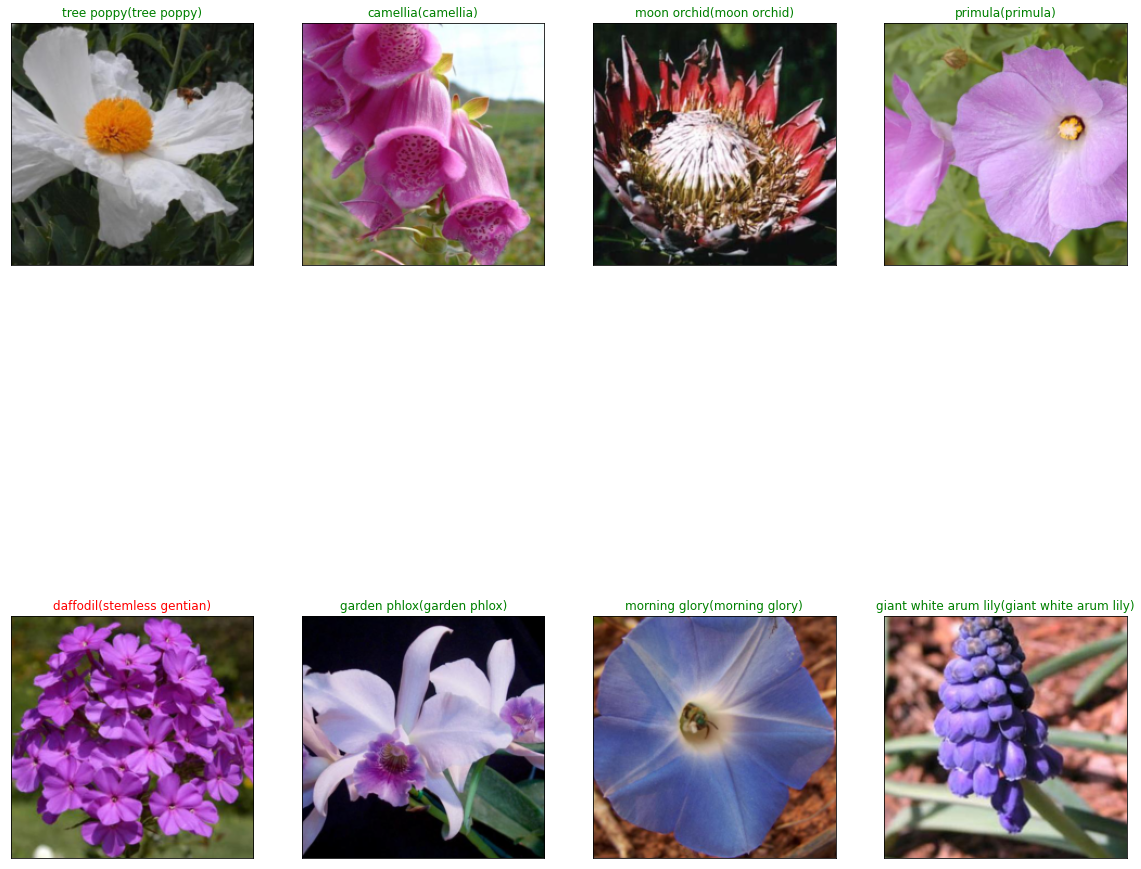

In [63]:
fig = plt.figure(figsize=(20,20))
rows = 2
cols = 4

for idx in range(rows*cols):
    ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(image[idx]))
    ax.set_title('{}({})'.format(cat_to_names[str(pred[idx])], cat_to_names[str(label[idx].item())]), 
                 color=('green' if cat_to_names[str(pred[idx])] ==  cat_to_names[str(label[idx].item())] else 'red' ))
                                                                                                 